# Ranked cell tower placement markers

/tmp/ipykernel_3220/1339122161.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers_points['geometry'] = cell_towers_points.geometry.centroid


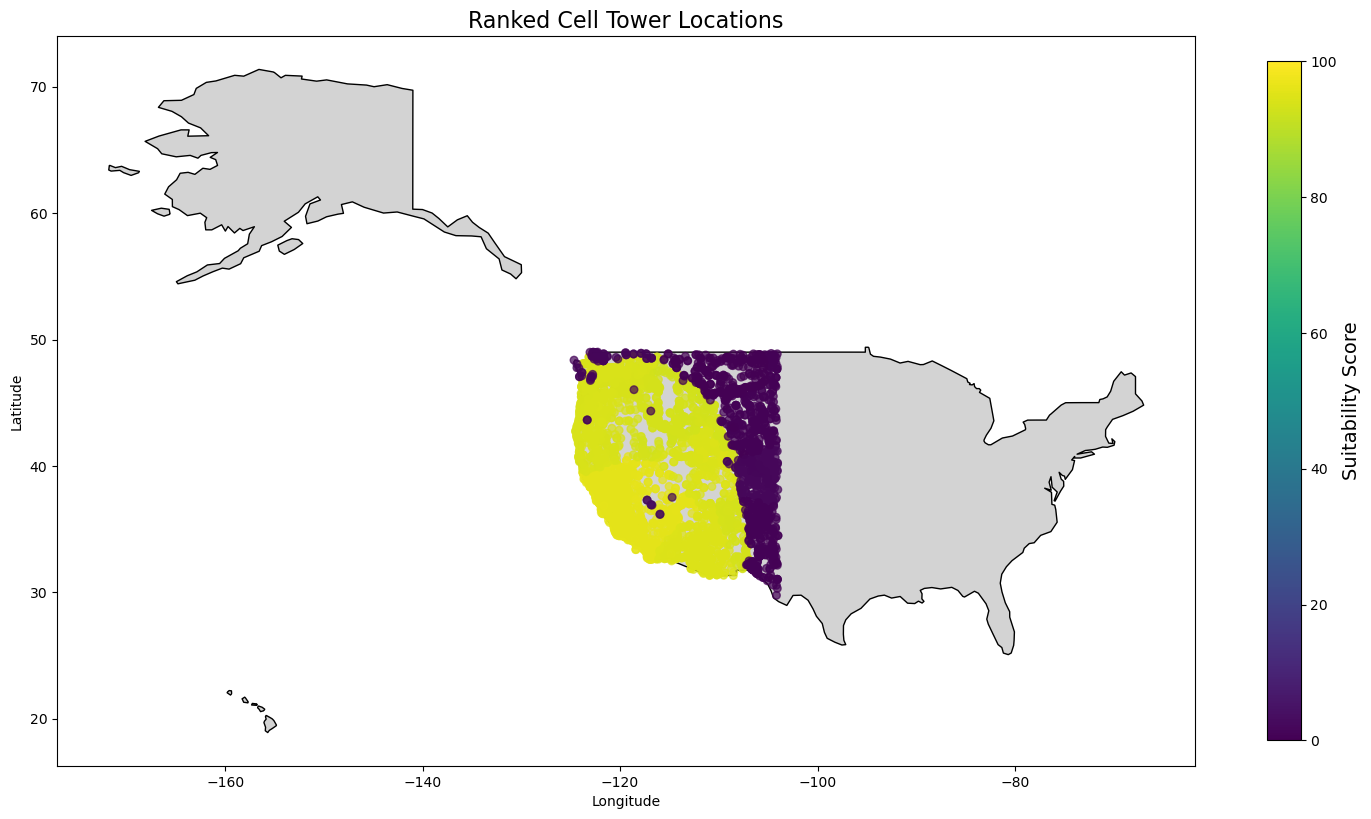

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import requests
import io

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Convert polygons to centroids to make them visible as points
cell_towers_points = cell_towers.copy()
cell_towers_points['geometry'] = cell_towers_points.geometry.centroid

# Get USA boundaries from direct URL
usa_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA.geo.json"
response = requests.get(usa_url)
usa = gpd.read_file(io.StringIO(response.content.decode('utf-8')))

# Make sure both datasets use the same CRS
usa = usa.to_crs(cell_towers_points.crs)

# Create figure with larger size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot USA boundaries
usa.plot(ax=ax, color='lightgray', edgecolor='black')

# Define the score column
score_column = 'suitability_score'  # Or use 'predicted_suitability_score'

# Create a colormap and normalize the color scale
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=cell_towers_points[score_column].min(),
    vmax=cell_towers_points[score_column].max()
)

# Plot cell tower locations as points with increased size
cell_towers_points.plot(
    ax=ax,
    column=score_column,
    cmap=cmap,
    markersize=30,
    alpha=0.7,
    legend=False
)

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
ax.set_title('Ranked Cell Tower Locations', fontsize=16)

# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_3220/4156959433.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid


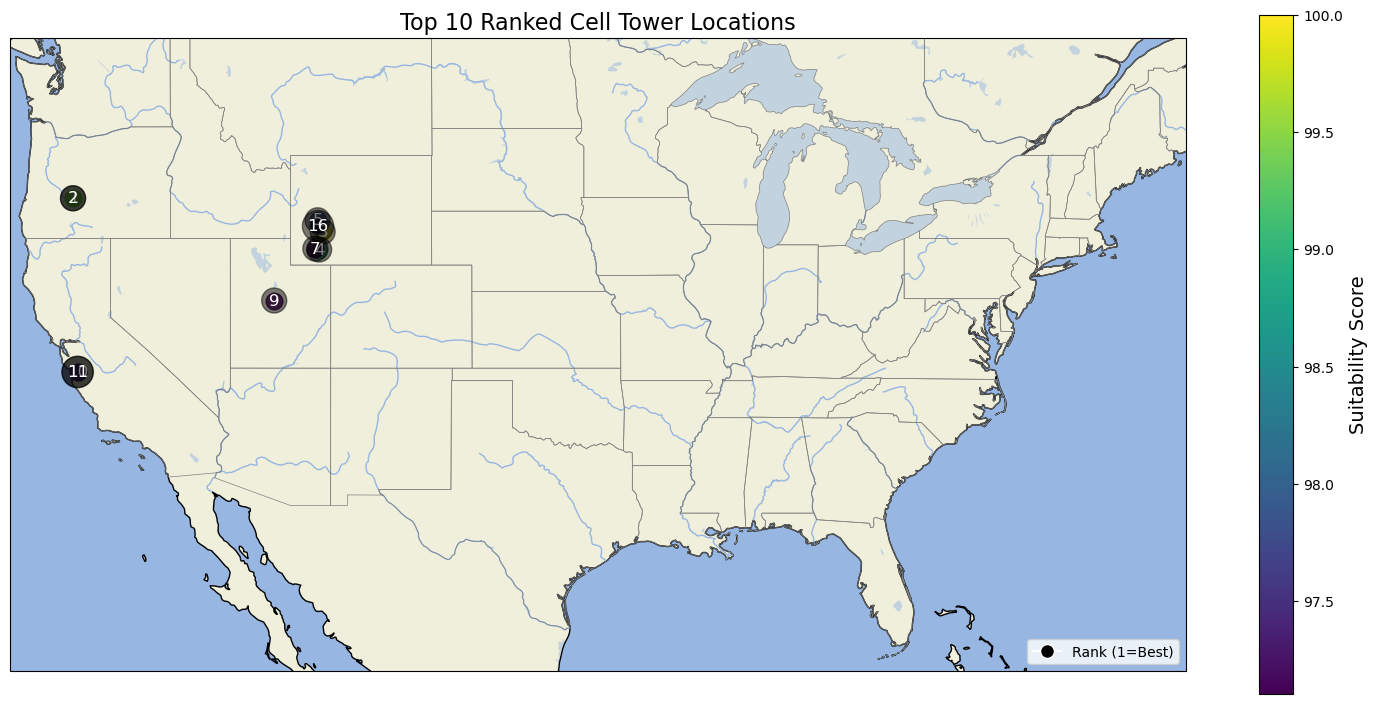

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import numpy as np

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Sort by suitability score in descending order and get top 10
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
top_10_towers = cell_towers.sort_values(by=score_column, ascending=False).head(10)

# Create a new GeoDataFrame with centroids as the geometry
# The key fix is here - we properly extract the centroid coordinates
top_10_points = gpd.GeoDataFrame(
    top_10_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_10_towers['centroid'],  # Use the centroid column as the geometry
    crs=cell_towers.crs
)

# Convert to Web Mercator projection for better display
top_10_points = top_10_points.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale for the top 10
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_10_points[score_column].min(),
    vmax=top_10_points[score_column].max()
)

# Plot the top 10 cell tower points
for idx, row in top_10_points.iterrows():
    # Now these will be Point geometries that have .x and .y attributes
    plt.plot(
        row.geometry.x, row.geometry.y,
        'o',
        markersize=12,
        color=cmap(norm(row[score_column])),
        transform=ccrs.epsg(3857),
        alpha=0.8
    )
    
    # Add a rank number
    plt.text(
        row.geometry.x, row.geometry.y,
        f"{idx+1}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='circle')
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 10 Ranked Cell Tower Locations', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3220/1377925085.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid


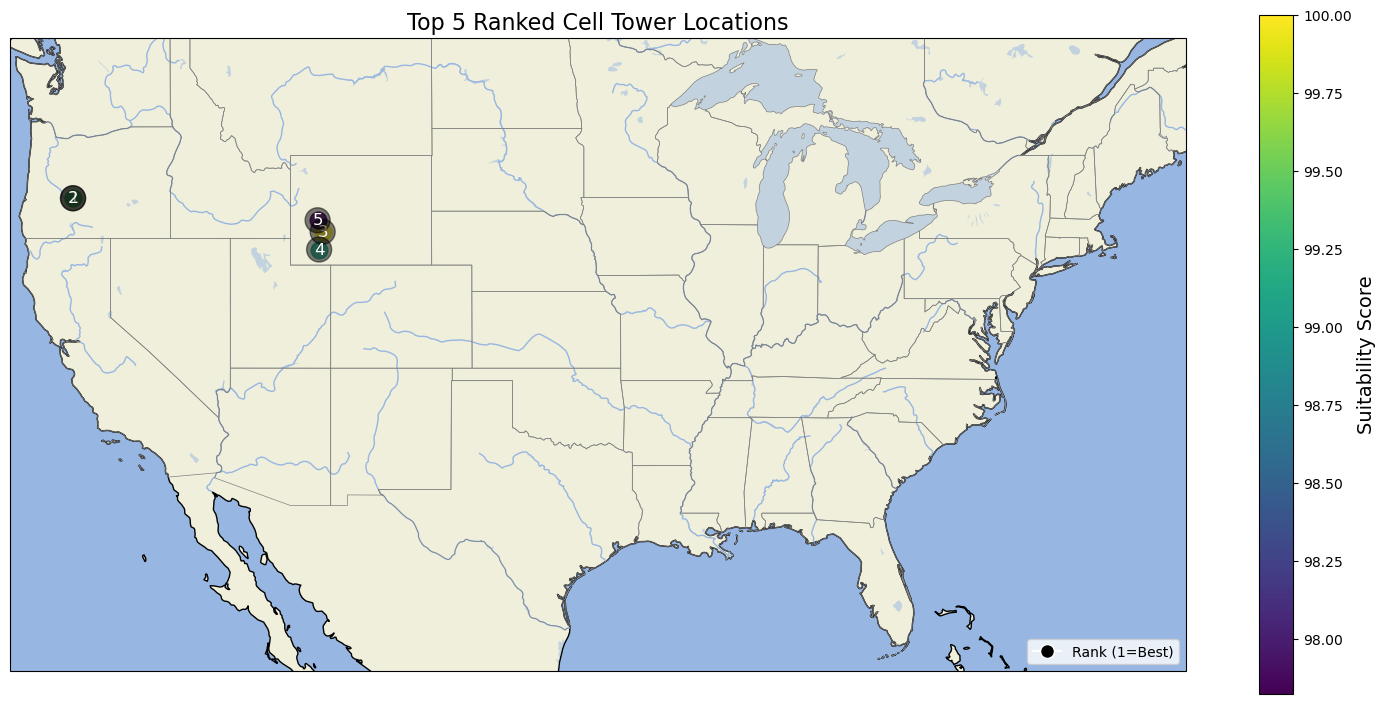

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import numpy as np

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Sort by suitability score in descending order and get top 10
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
top_5_towers = cell_towers.sort_values(by=score_column, ascending=False).head(5)

# Create a new GeoDataFrame with centroids as the geometry
# The key fix is here - we properly extract the centroid coordinates
top_5_points = gpd.GeoDataFrame(
    top_5_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_5_towers['centroid'],  # Use the centroid column as the geometry
    crs=cell_towers.crs
)

# Convert to Web Mercator projection for better display
top_5_points = top_5_points.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale for the top 10
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_5_points[score_column].min(),
    vmax=top_5_points[score_column].max()
)

# Plot the top 10 cell tower points
for idx, row in top_5_points.iterrows():
    # Now these will be Point geometries that have .x and .y attributes
    plt.plot(
        row.geometry.x, row.geometry.y,
        'o',
        markersize=12,
        color=cmap(norm(row[score_column])),
        transform=ccrs.epsg(3857),
        alpha=0.8
    )
    
    # Add a rank number
    plt.text(
        row.geometry.x, row.geometry.y,
        f"{idx+1}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='circle')
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 5 Ranked Cell Tower Locations', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from collections import defaultdict
from shapely.geometry import box

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Define continental US bounding box (exclude Alaska, Hawaii)
# Approximate boundaries for continental US
continental_us_bounds = box(-125, 24, -66.5, 49)
continental_us = gpd.GeoDataFrame(geometry=[continental_us_bounds], crs="EPSG:4326")

# Filter cell towers to only include those in continental US
mainland_towers = gpd.sjoin(cell_towers, continental_us, predicate='within')

# Use cartopy's state boundaries for extracting state information
states = cfeature.NaturalEarthFeature(
    category='cultural', 
    name='admin_1_states_provinces_lines', 
    scale='50m'
)

# Get the state geometries as a GeoDataFrame
state_geometries = gpd.GeoDataFrame(
    geometry=[feature.geometry for feature in states.geometries()],
    crs="EPSG:4326"
)

# Add a state_id identifier (we'll just use the index since we don't have state names)
state_geometries['state_id'] = state_geometries.index

# Assign state IDs to each tower
mainland_towers = gpd.sjoin(mainland_towers, state_geometries, predicate='within')

# Sort by suitability score in descending order
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
sorted_towers = mainland_towers.sort_values(by=score_column, ascending=False)

# Select top towers with max 2 per state
selected_towers = []
state_counts = defaultdict(int)

for idx, tower in sorted_towers.iterrows():
    if pd.isna(tower['state_id']):
        continue  # Skip towers that don't have a state assignment
        
    state_id = tower['state_id']
    if state_counts[state_id] < 2:
        selected_towers.append(tower)
        state_counts[state_id] += 1
    
    # Stop once we have 5 towers
    if len(selected_towers) >= 5:
        break

# If we don't have 5 towers yet, add more from the remaining states
if len(selected_towers) < 5:
    for idx, tower in sorted_towers.iterrows():
        if tower not in selected_towers:
            selected_towers.append(tower)
        
        if len(selected_towers) >= 5:
            break

# Create a GeoDataFrame from selected towers
top_towers = gpd.GeoDataFrame(selected_towers)

# Create a new GeoDataFrame with centroids as the geometry
top_points = gpd.GeoDataFrame(
    top_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_towers['centroid'],  # Use the centroid column as the geometry
    crs=mainland_towers.crs
)

# Convert to Web Mercator projection for better display
top_points = top_points.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_points[score_column].min(),
    vmax=top_points[score_column].max()
)

# Create new rank based on the filtered selection
top_points['rank'] = range(1, len(top_points) + 1)

# Plot the selected cell tower points
for idx, row in top_points.iterrows():
    plt.plot(
        row.geometry.x, row.geometry.y,
        'o',
        markersize=15,  # Increased size for better visibility
        color=cmap(norm(row[score_column])),
        transform=ccrs.epsg(3857),
        alpha=0.8,
        zorder=10  # Ensure points are on top
    )
    
    # Add a rank number
    plt.text(
        row.geometry.x, row.geometry.y,
        f"{row['rank']}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='circle'),
        zorder=11  # Ensure text is on top of points
    )

    # Add state ID as annotation (since we don't have state names)
    state_id = row['state_id'] if not pd.isna(row['state_id']) else "Unknown"
    plt.annotate(
        f"State ID: {state_id}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
        transform=ccrs.epsg(3857),
        zorder=11
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 5 Ranked Cell Tower Locations - Continental US\n(Maximum 2 towers per state)', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_161/3238852025.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid


ValueError: 'index_right' cannot be a column name in the frames being joined

/tmp/ipykernel_161/2690652010.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid
/tmp/ipykernel_161/2690652010.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mainland_towers.centroid.x,
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_161/2690652010.py:39: UserWarning: Geometry is in a geograp

ValueError: 'transform' is not allowed as a keyword argument; axvline generates its own transform.

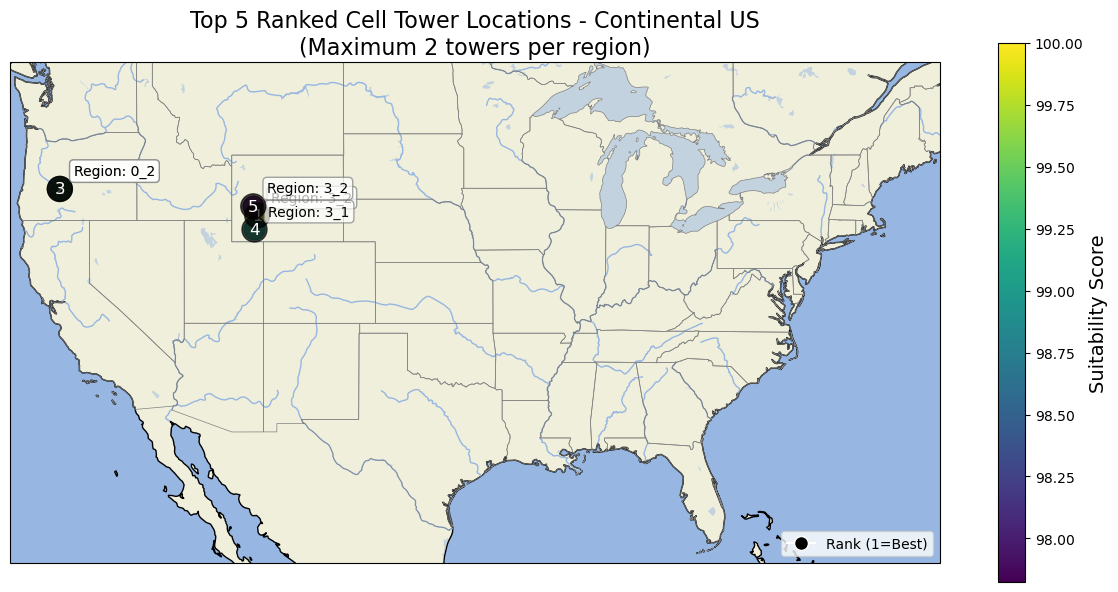

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from collections import defaultdict
from shapely.geometry import box
import pandas as pd

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Define continental US bounding box (exclude Alaska, Hawaii)
continental_us_bounds = box(-125, 24, -66.5, 49)

# Filter cell towers using the .within() method instead of sjoin
mainland_towers = cell_towers[cell_towers.geometry.within(continental_us_bounds)]

# Instead of using spatial join for state assignment, let's create a simple
# grid-based division of the continental US to ensure tower diversity
# This divides the US into regions and we'll limit towers per region

# Create a simple grid by dividing the US into regions
mainland_towers['region_x'] = pd.cut(
    mainland_towers.centroid.x, 
    bins=5, 
    labels=False
)
mainland_towers['region_y'] = pd.cut(
    mainland_towers.centroid.y,
    bins=3, 
    labels=False
)
mainland_towers['region_id'] = mainland_towers['region_x'].astype(str) + '_' + mainland_towers['region_y'].astype(str)

# Sort by suitability score in descending order
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
sorted_towers = mainland_towers.sort_values(by=score_column, ascending=False)

# Select top towers with max 2 per region
selected_towers = []
region_counts = defaultdict(int)

for idx, tower in sorted_towers.iterrows():
    region_id = tower['region_id']
    if region_counts[region_id] < 2:
        selected_towers.append(tower)
        region_counts[region_id] += 1
    
    # Stop once we have 5 towers
    if len(selected_towers) >= 5:
        break

# If we don't have 5 towers yet, add more from the remaining regions
if len(selected_towers) < 5:
    for idx, tower in sorted_towers.iterrows():
        if any(tower.equals(selected) for selected in selected_towers):
            continue
        selected_towers.append(tower)
        if len(selected_towers) >= 5:
            break

# Create a GeoDataFrame from selected towers
top_towers = gpd.GeoDataFrame(selected_towers)

# Create a new GeoDataFrame with centroids as the geometry
top_points = gpd.GeoDataFrame(
    top_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_towers['centroid'],  # Use the centroid column as the geometry
    crs=mainland_towers.crs
)

# Convert to Web Mercator projection for better display
top_points = top_points.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_points[score_column].min(),
    vmax=top_points[score_column].max()
)

# Create new rank based on the filtered selection
top_points['rank'] = range(1, len(top_points) + 1)

# Get coordinates for each point for annotations
coords = {}
for idx, row in top_points.iterrows():
    coords[idx] = (
        row.geometry.x, 
        row.geometry.y,
        row['rank'],
        row[score_column],
        row['region_id']
    )

# Plot the selected cell tower points
for idx, (x, y, rank, score, region_id) in coords.items():
    plt.plot(
        x, y,
        'o',
        markersize=15,  # Increased size for better visibility
        color=cmap(norm(score)),
        transform=ccrs.epsg(3857),
        alpha=0.8,
        zorder=10  # Ensure points are on top
    )
    
    # Add a rank number
    plt.text(
        x, y,
        f"{rank}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='circle'),
        zorder=11  # Ensure text is on top of points
    )

    # Add region ID as annotation
    plt.annotate(
        f"Region: {region_id}",
        xy=(x, y),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
        transform=ccrs.epsg(3857),
        zorder=11
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 5 Ranked Cell Tower Locations - Continental US', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)')
]
ax.legend(handles=legend_elements, loc='lower right')

# Optional: Draw grid lines to show the regions
for i in range(6):
    x = continental_us_bounds.bounds[0] + i * (continental_us_bounds.bounds[2] - continental_us_bounds.bounds[0]) / 5
    plt.axvline(x, color='gray', linestyle='--', alpha=0.3, transform=ccrs.PlateCarree())

for i in range(4):
    y = continental_us_bounds.bounds[1] + i * (continental_us_bounds.bounds[3] - continental_us_bounds.bounds[1]) / 3
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

/tmp/ipykernel_161/430860237.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


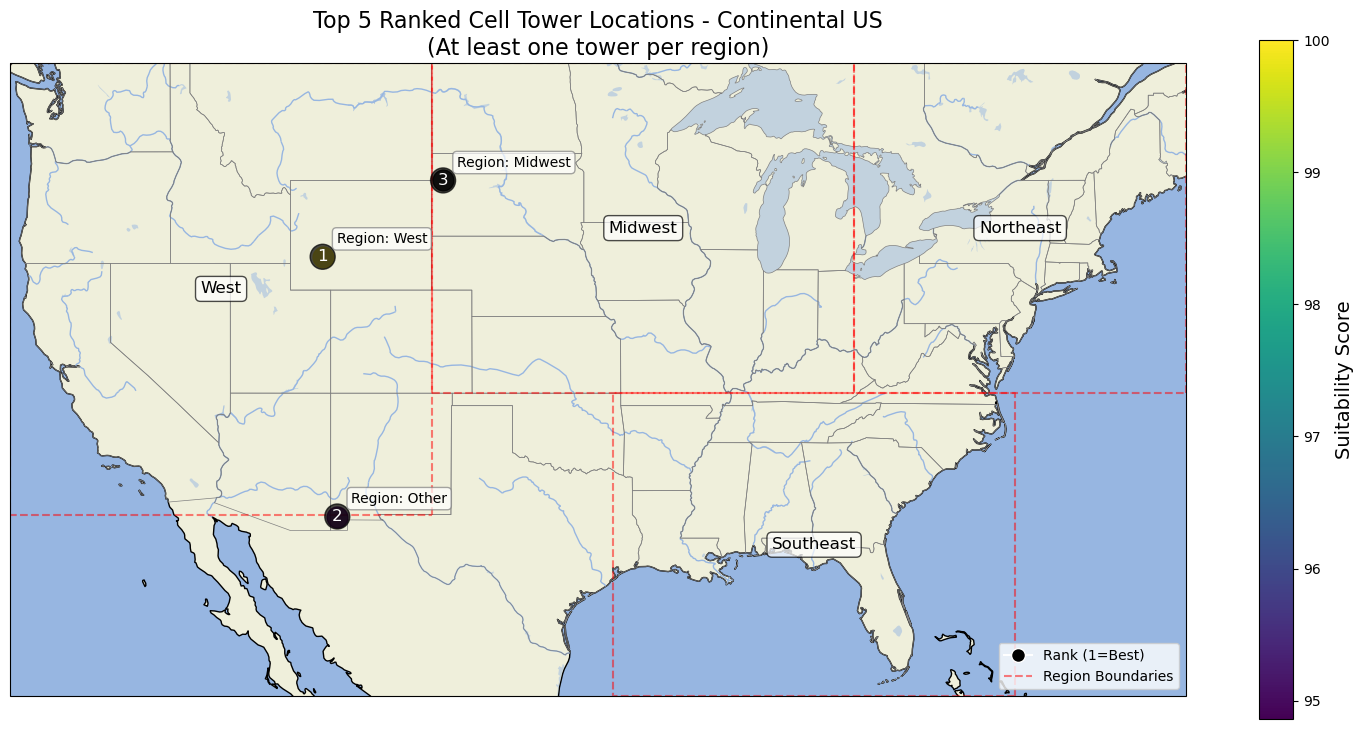

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from collections import defaultdict
from shapely.geometry import box
import pandas as pd

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Define continental US bounding box (exclude Alaska, Hawaii)
continental_us_bounds = box(-125, 24, -66.5, 49)

# Filter cell towers using the .within() method
mainland_towers = cell_towers[cell_towers.geometry.within(continental_us_bounds)]

# Define regions more specifically to ensure geographic diversity
# We'll divide the US into 4 regions to avoid concentration in Wyoming
regions = {
    'Northeast': box(-83, 37, -66.5, 49),     # Northeast US
    'Southeast': box(-95, 24, -75, 37),       # Southeast US
    'Midwest': box(-104, 37, -83, 49),        # Midwest US
    'West': box(-125, 32, -104, 49)           # Western US
}

# Assign each tower to a region
mainland_towers['region'] = 'Other'
for region_name, region_geom in regions.items():
    region_mask = mainland_towers.geometry.within(region_geom)
    mainland_towers.loc[region_mask, 'region'] = region_name

# Sort by suitability score in descending order
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
sorted_towers = mainland_towers.sort_values(by=score_column, ascending=False)

# First pass: Get top tower from each defined region
selected_towers = []
selected_regions = set()

# First ensure we get at least one tower from each major region
for region_name in regions.keys():
    # Get the highest-scoring tower from this region
    region_towers = sorted_towers[sorted_towers['region'] == region_name]
    if not region_towers.empty:
        selected_towers.append(region_towers.iloc[0])
        selected_regions.add(region_name)

# If we still need more towers to reach 5, get the highest scoring remaining towers
remaining_towers = sorted_towers[~sorted_towers.index.isin([t.name for t in selected_towers])]
for _, tower in remaining_towers.iterrows():
    # Don't select more than 2 from any region
    if tower['region'] in selected_regions and sum(1 for t in selected_towers if t['region'] == tower['region']) >= 1:
        continue
    
    selected_towers.append(tower)
    selected_regions.add(tower['region'])
    
    if len(selected_towers) >= 5:
        break

# Create a GeoDataFrame from selected towers
top_towers = gpd.GeoDataFrame(selected_towers)

# Create a new GeoDataFrame with centroids as the geometry
top_points = gpd.GeoDataFrame(
    top_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_towers['centroid'],  # Use the centroid column as the geometry
    crs=mainland_towers.crs
)

# Convert to Web Mercator projection for better display
top_points = top_points.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_points[score_column].min(),
    vmax=top_points[score_column].max()
)

# Create new rank based on the filtered selection
top_points = top_points.sort_values(by=score_column, ascending=False)
top_points['rank'] = range(1, len(top_points) + 1)

# Plot the selected cell tower points
for idx, row in top_points.iterrows():
    plt.plot(
        row.geometry.x, row.geometry.y,
        'o',
        markersize=15,  # Increased size for better visibility
        color=cmap(norm(row[score_column])),
        transform=ccrs.epsg(3857),
        alpha=0.8,
        zorder=10  # Ensure points are on top
    )
    
    # Add a rank number
    plt.text(
        row.geometry.x, row.geometry.y,
        f"{row['rank']}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='circle'),
        zorder=11  # Ensure text is on top of points
    )

    # Add region name as annotation
    plt.annotate(
        f"Region: {row['region']}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(10, 10),  
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
        transform=ccrs.epsg(3857),
        zorder=11
    )

# Draw region boundaries
for region_name, region_geom in regions.items():
    # Convert to Web Mercator for display
    region_gdf = gpd.GeoDataFrame(geometry=[region_geom], crs="EPSG:4326").to_crs(epsg=3857)
    region_gdf.boundary.plot(ax=ax, color='red', linestyle='--', alpha=0.5, transform=ccrs.epsg(3857))
    
    # Add region labels
    centroid = region_gdf.geometry[0].centroid
    plt.text(
        centroid.x, centroid.y,
        region_name,
        fontsize=12,
        ha='center',
        va='center',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 5 Ranked Cell Tower Locations - Continental US\n(At least one tower per region)', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)'),
    Line2D([0], [0], color='red', linestyle='--', alpha=0.5, label='Region Boundaries')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_161/3054673559.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_towers['centroid'] = cell_towers.geometry.centroid
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Number of selected points: 5


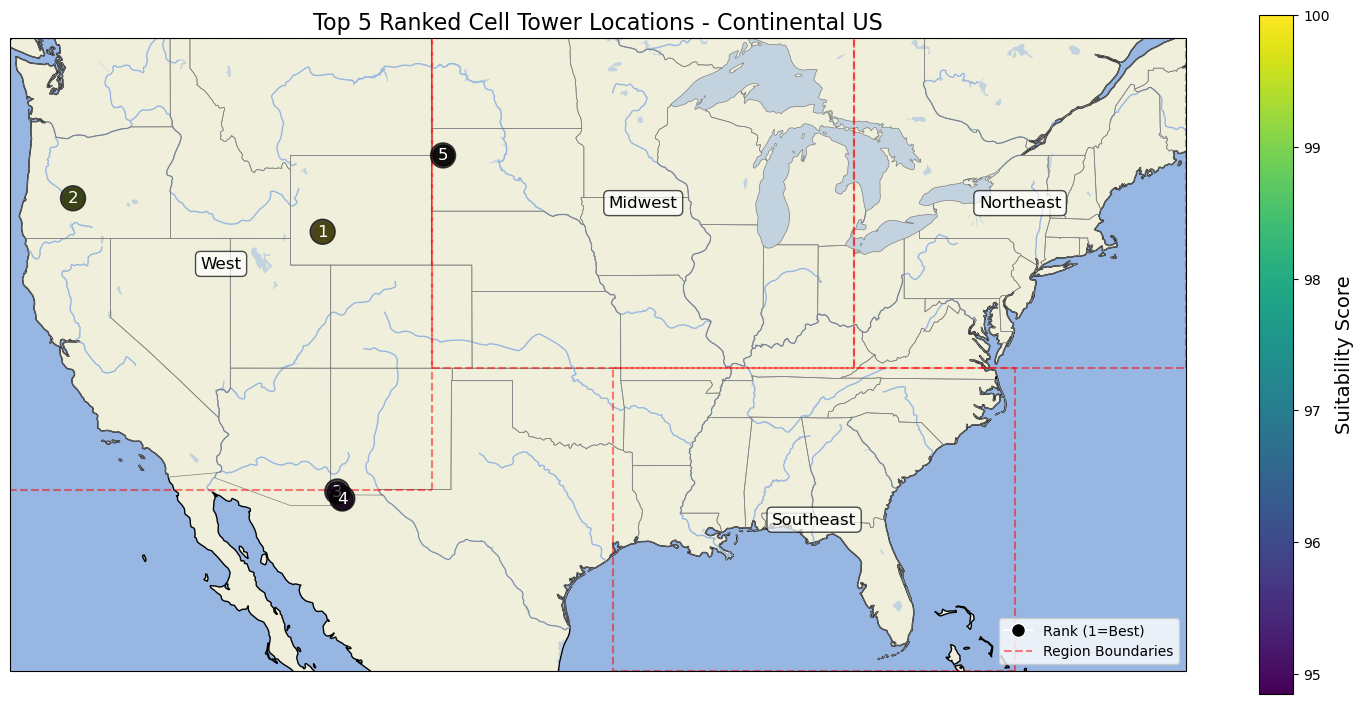

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from collections import defaultdict
from shapely.geometry import box
import pandas as pd

# Load the GeoJSON file with cell tower locations
cell_towers = gpd.read_file('ranked_cell_tower_locations.geojson')

# Make sure the CRS is set correctly
if cell_towers.crs is None:
    cell_towers = cell_towers.set_crs(epsg=4326)

# Calculate centroids but keep original geometry
cell_towers['centroid'] = cell_towers.geometry.centroid

# Define continental US bounding box (exclude Alaska, Hawaii)
continental_us_bounds = box(-125, 24, -66.5, 49)

# Filter cell towers using the .within() method
mainland_towers = cell_towers[cell_towers.geometry.within(continental_us_bounds)]

# Define regions more specifically to ensure geographic diversity
# We'll divide the US into 4 regions to avoid concentration in Wyoming
regions = {
    'Northeast': box(-83, 37, -66.5, 49),     # Northeast US
    'Southeast': box(-95, 24, -75, 37),       # Southeast US
    'Midwest': box(-104, 37, -83, 49),        # Midwest US
    'West': box(-125, 32, -104, 49)           # Western US
}

# Assign each tower to a region
mainland_towers['region'] = 'Other'
for region_name, region_geom in regions.items():
    region_mask = mainland_towers.geometry.within(region_geom)
    mainland_towers.loc[region_mask, 'region'] = region_name

# Sort by suitability score in descending order
score_column = 'suitability_score'  # Change if using 'predicted_suitability_score'
sorted_towers = mainland_towers.sort_values(by=score_column, ascending=False)

# Initialize list to store selected towers
selected_towers = []
region_counts = defaultdict(int)

# First, ensure we get the best tower from each region
for region_name in regions.keys():
    region_towers = sorted_towers[sorted_towers['region'] == region_name]
    if not region_towers.empty:
        selected_towers.append(region_towers.iloc[0])
        region_counts[region_name] += 1

# Then add highest scoring remaining towers until we reach 5, limiting to 2 per region
remaining_towers = sorted_towers[~sorted_towers.index.isin([t.name for t in selected_towers])]
for _, tower in remaining_towers.iterrows():
    region = tower['region']
    # Don't select more than 2 from any region
    if region_counts[region] < 2:
        selected_towers.append(tower)
        region_counts[region] += 1
    
    if len(selected_towers) >= 5:
        break

# If we still don't have 5 towers, relax the region constraint
if len(selected_towers) < 5:
    still_remaining = sorted_towers[~sorted_towers.index.isin([t.name for t in selected_towers])]
    for _, tower in still_remaining.iterrows():
        selected_towers.append(tower)
        if len(selected_towers) >= 5:
            break

# Create a GeoDataFrame from selected towers
top_towers = gpd.GeoDataFrame(selected_towers)

# Create a new GeoDataFrame with centroids as the geometry
top_points = gpd.GeoDataFrame(
    top_towers.drop(columns=['centroid']),  # Remove centroid column to avoid confusion
    geometry=top_towers['centroid'],  # Use the centroid column as the geometry
    crs=mainland_towers.crs
)

# Convert to Web Mercator projection for better display
top_points = top_points.to_crs(epsg=3857)

# Sort by suitability score and assign ranks
top_points = top_points.sort_values(by=score_column, ascending=False)
top_points['rank'] = range(1, len(top_points) + 1)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a colormap and normalize the color scale
cmap = plt.cm.viridis
norm = colors.Normalize(
    vmin=top_points[score_column].min(),
    vmax=top_points[score_column].max()
)

# Print the number of selected points for verification
print(f"Number of selected points: {len(top_points)}")

# Plot the selected cell tower points
for idx, row in top_points.iterrows():
    plt.plot(
        row.geometry.x, row.geometry.y,
        'o',
        markersize=15,  # Increased size for better visibility
        color=cmap(norm(row[score_column])),
        transform=ccrs.epsg(3857),
        alpha=0.8,
        zorder=10  # Ensure points are on top
    )
    
    # Add a rank number
    plt.text(
        row.geometry.x, row.geometry.y,
        f"{row['rank']}",
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='circle'),
        zorder=11  # Ensure text is on top of points
    )

    

# Draw region boundaries
for region_name, region_geom in regions.items():
    # Convert to Web Mercator for display
    region_gdf = gpd.GeoDataFrame(geometry=[region_geom], crs="EPSG:4326").to_crs(epsg=3857)
    region_gdf.boundary.plot(ax=ax, color='red', linestyle='--', alpha=0.5, transform=ccrs.epsg(3857))
    
    # Add region labels
    centroid = region_gdf.geometry[0].centroid
    plt.text(
        centroid.x, centroid.y,
        region_name,
        fontsize=12,
        ha='center',
        va='center',
        transform=ccrs.epsg(3857),
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

# Add a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Suitability Score', size=14)

# Set title
plt.title('Top 5 Ranked Cell Tower Locations - Continental US', fontsize=16)

# Add a legend for the rank numbers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Rank (1=Best)'),
    Line2D([0], [0], color='red', linestyle='--', alpha=0.5, label='Region Boundaries')
]
ax.legend(handles=legend_elements, loc='lower right')



plt.tight_layout()
plt.show()

# Cell tower connectivity coverage currently

/tmp/ipykernel_161/3175310986.py:42: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')
/tmp/ipykernel_161/3175310986.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


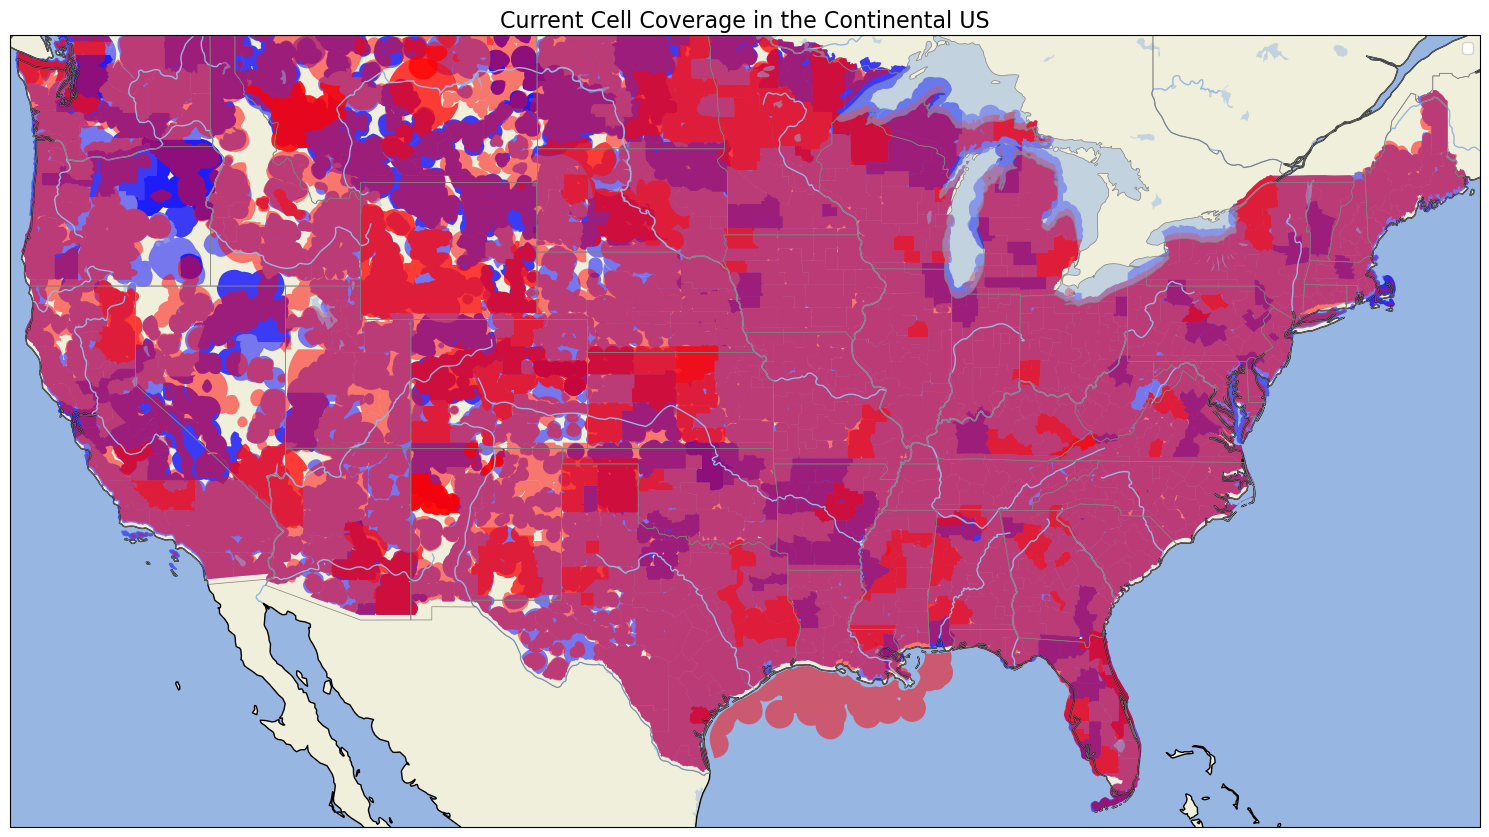

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the GeoJSON files
a_block = gpd.read_file('A_Block_CGSA.geojson')
b_block = gpd.read_file('B_Block_CGSA.geojson')

# Ensure the CRS is set correctly (EPSG:4326 for lat/lon)
if a_block.crs is None:
    a_block = a_block.set_crs(epsg=4326)
if b_block.crs is None:
    b_block = b_block.set_crs(epsg=4326)

# Convert to Web Mercator projection for better display
a_block = a_block.to_crs(epsg=3857)
b_block = b_block.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Plot the A and B block coverage areas
a_block.plot(ax=ax, color='blue', alpha=0.5, label='A Block Coverage')
b_block.plot(ax=ax, color='red', alpha=0.5, label='B Block Coverage')

# Add legend
ax.legend(loc='upper right')

# Set title
plt.title('Current Cell Coverage in the Continental US', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

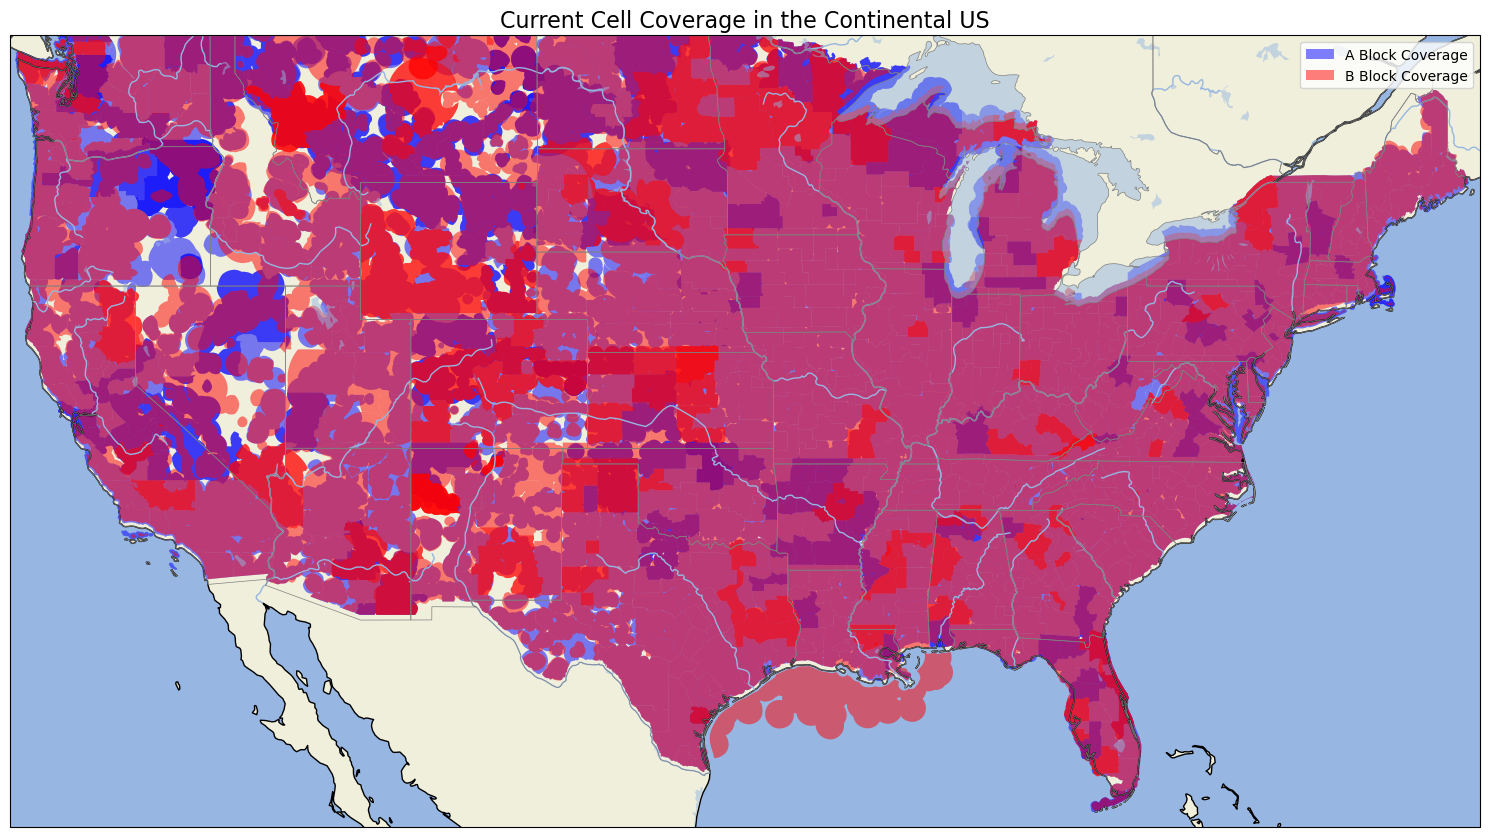

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Load the GeoJSON files
a_block = gpd.read_file('A_Block_CGSA.geojson')
b_block = gpd.read_file('B_Block_CGSA.geojson')

# Ensure the CRS is set correctly (EPSG:4326 for lat/lon)
if a_block.crs is None:
    a_block = a_block.set_crs(epsg=4326)
if b_block.crs is None:
    b_block = b_block.set_crs(epsg=4326)

# Convert to Web Mercator projection for better display
a_block = a_block.to_crs(epsg=3857)
b_block = b_block.to_crs(epsg=3857)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add state boundaries
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Plot the A and B block coverage areas
a_block.plot(ax=ax, color='blue', alpha=0.5, label='A Block Coverage')
b_block.plot(ax=ax, color='red', alpha=0.5, label='B Block Coverage')

# Create custom legend handles
legend_elements = [
    Patch(facecolor='blue', alpha=0.5, label='A Block Coverage'),
    Patch(facecolor='red', alpha=0.5, label='B Block Coverage')
]

# Add legend
ax.legend(handles=legend_elements, loc='upper right')

# Set title
plt.title('Current Cell Coverage in the Continental US', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# elevation map of the US

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the DEM file
dem_file = 'US_merged.tif'
with rasterio.open(dem_file) as src:
    # Read the elevation data
    elevation = src.read(1)
    # Get the transform and extent of the DEM
    transform = src.transform
    width = src.width
    height = src.height
    bounds = src.bounds

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Plot the DEM data
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
dem_plot = ax.imshow(
    elevation,
    extent=extent,
    transform=ccrs.PlateCarree(),
    cmap='terrain',  # Use a terrain colormap for elevation
    origin='upper',  # DEM data is typically stored with origin at the top
    alpha=0.8  # Adjust transparency if needed
)

# Add a colorbar
cbar = plt.colorbar(dem_plot, ax=ax, shrink=0.7)
cbar.set_label('Elevation (meters)', size=14)

# Set title
plt.title('Elevation Map of the Continental US', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

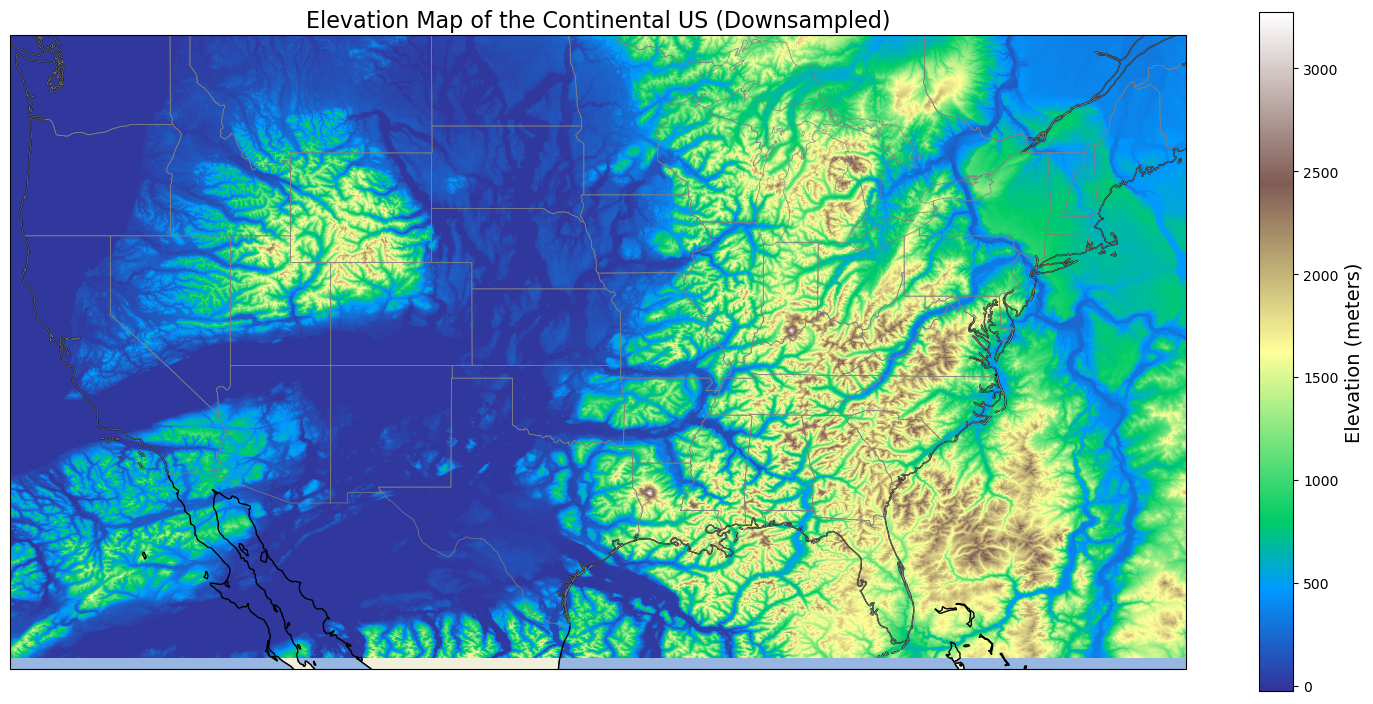

In [2]:
import rasterio
from rasterio.windows import Window  # Import the Window class
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the DEM file with downsampling
dem_file = 'US_merged.tif'
with rasterio.open(dem_file) as src:
    # Downsample by reading every 10th pixel (adjust as needed)
    downscale_factor = 10
    elevation = src.read(1, window=Window(0, 0, src.width // downscale_factor, src.height // downscale_factor))
    transform = src.transform * src.transform.scale(downscale_factor, downscale_factor)
    bounds = src.bounds

# Convert to float32 to save memory
elevation = elevation.astype(np.float32)

# Create a figure with a larger size using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Set the extent to cover the continental US
ax.set_extent([-125, -66.5, 24, 49], ccrs.PlateCarree())

# Add physical features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# Create a grid for pcolormesh
x = np.linspace(bounds.left, bounds.right, elevation.shape[1])
y = np.linspace(bounds.bottom, bounds.top, elevation.shape[0])
X, Y = np.meshgrid(x, y)

# Plot the DEM using pcolormesh
dem_plot = ax.pcolormesh(
    X, Y, elevation,
    transform=ccrs.PlateCarree(),
    cmap='terrain',
    shading='auto'
)

# Add a colorbar
cbar = plt.colorbar(dem_plot, ax=ax, shrink=0.7)
cbar.set_label('Elevation (meters)', size=14)

# Set title
plt.title('Elevation Map of the Continental US (Downsampled)', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()